In [162]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import gc

import preprocessing

import os
import warnings
warnings.filterwarnings('ignore')

In [163]:
seed = 42
def kFold(clf, X, y, k = 5):
    tprs = []
    accuracy = 0 
    roc_auc = 0
    precision = 0
    recall = 0
    mean_fpr = np.linspace(0,1,50)
    cv = StratifiedKFold(n_splits=k, random_state=seed)
    
    for train, test in cv.split(X,y):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        
        clf.fit(X_train, y_train)
        predict_test = clf.predict(X_test)
        accuracy += accuracy_score(y_test, predict_test)
        precision += precision_score(y_test, predict_test)
        recall += recall_score(y_test, predict_test)
        
        predict_proba_test = clf.predict_proba(X_test)
        fpr, tpr, t = roc_curve(y_test, predict_proba_test[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc += roc_auc_score(y_test, predict_proba_test[:, 1])
        
    accuracy /= 5
    roc_auc /= 5
    precision /= 5
    recall /= 5
    mean_tpr = np.mean(tprs, axis=0)
    
    return accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr

In [164]:
train_app = preprocessing.read_application()
train_app = train_app[train_app['TARGET'].isnull() == False]
train = pd.read_csv('train.csv')
train_app.index = train.index


In [165]:
np.random.seed(seed)
rows = np.random.choice(train.index.values, int(len(train) * 0.2))
train = train.ix[rows]
train_app = train_app.ix[rows]
target = train['TARGET']
train = train.drop(columns= ['TARGET', 'SK_ID_CURR', 'Unnamed: 0'])
target_app = train_app['TARGET']
train_app = train_app.drop(columns= ['TARGET', 'SK_ID_CURR'])

In [166]:
pipe_ada = make_pipeline(Imputer(strategy = 'median'),
                       StandardScaler(),
                       AdaBoostClassifier())

In [167]:
from collections import defaultdict
scores = defaultdict(list)

## application data v.s. all data

In [168]:
accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr = kFold(pipe_ada ,train_app, target_app)

scores['accuracy'].append(accuracy)
scores['roc_auc'].append(roc_auc)
scores['precision'].append(precision)
scores['recall'].append(recall)
scores['mean_tpr'].append(mean_tpr)

In [169]:
accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr = kFold(pipe_ada ,train, target)

scores['accuracy'].append(accuracy)
scores['roc_auc'].append(roc_auc)
scores['precision'].append(precision)
scores['recall'].append(recall)
scores['mean_tpr'].append(mean_tpr)

In [170]:
del train, train_app, target, target_app
gc.collect()

train = pd.read_csv('train_after_selection.csv')


In [171]:
train = train.ix[rows]
target = train['TARGET']
train = train.drop(columns= ['TARGET', 'SK_ID_CURR'])

In [172]:
accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr = kFold(pipe_ada ,train, target)

scores['accuracy'].append(accuracy)
scores['roc_auc'].append(roc_auc)
scores['precision'].append(precision)
scores['recall'].append(recall)
scores['mean_tpr'].append(mean_tpr)

In [42]:
from collections import defaultdict
scores = defaultdict(list)

In [173]:
from imblearn.over_sampling import SMOTE
class pipe_SMOTE:
    def __init__(self):
        self.imputer = Imputer(strategy = 'median')
        self.scaler = StandardScaler()
        self.smote = SMOTE(sampling_strategy=1.0, n_jobs=-1)
        self.ada = AdaBoostClassifier()
        
    def fit(self, X, y):
        X = self.imputer.fit_transform(X)
        X = self.scaler.fit_transform(X)
        X, y = self.smote.fit_resample(X,y)
        self.ada.fit(X,y)
    
    def predict(self, X):
        X = self.imputer.transform(X)
        X = self.scaler.transform(X)
        return self.ada.predict(X)
    
    def predict_proba(self, X):
        X = self.imputer.transform(X)
        X = self.scaler.transform(X)
        return self.ada.predict_proba(X)

In [174]:
pipe_smote = pipe_SMOTE()
accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr = kFold(pipe_smote ,train, target)

scores['accuracy'].append(accuracy)
scores['roc_auc'].append(roc_auc)
scores['precision'].append(precision)
scores['recall'].append(recall)
scores['mean_tpr'].append(mean_tpr)

In [175]:
mean_tprs = scores['mean_tpr']
name = ['only application', 'all data', 'feature selection', 'over-sampled data']

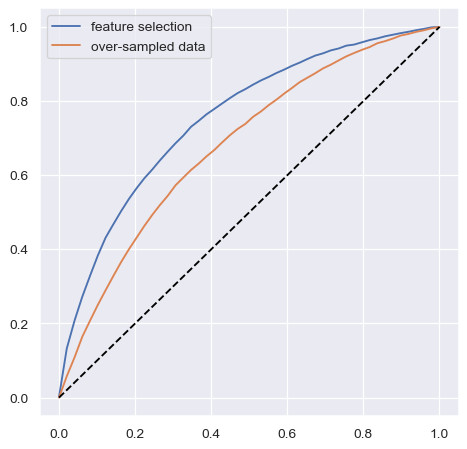

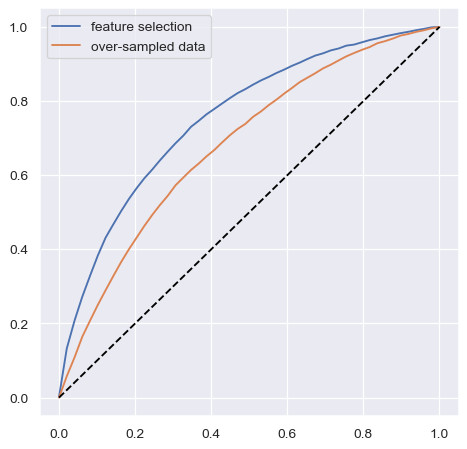

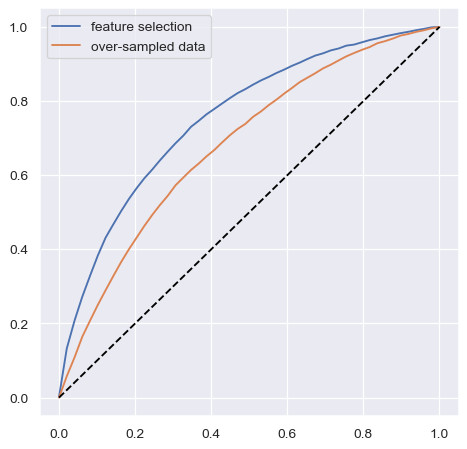

In [197]:
sns.set()
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['figure.dpi'] = 90
for k in range(2,5):
    for i in range(2,4):
        mean_tpr = mean_tprs[i]
        plt.plot(mean_fpr, mean_tpr,label = name[i])
    plt.plot([0,1],[0,1],linestyle = '--',color = 'black')
    plt.legend()
    plt.show()

In [188]:
del scores['mean_tpr']

In [189]:
scores_temp = scores
scores = pd.DataFrame(scores, index = name)

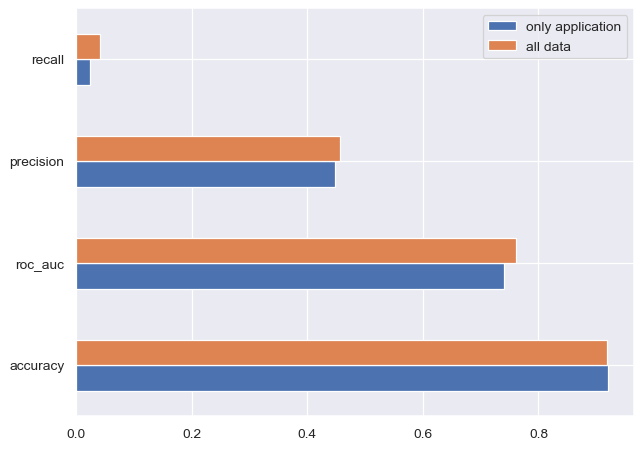

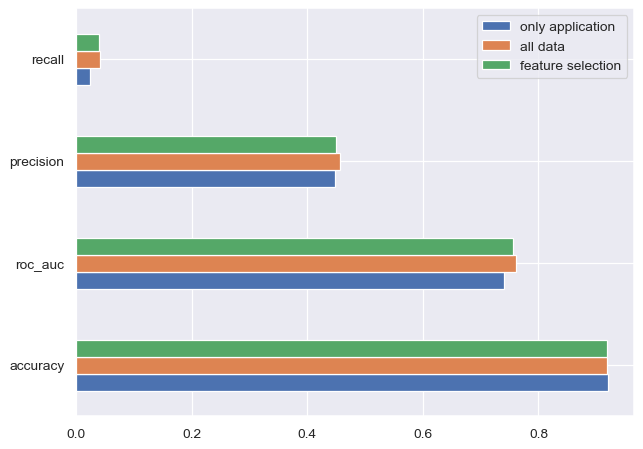

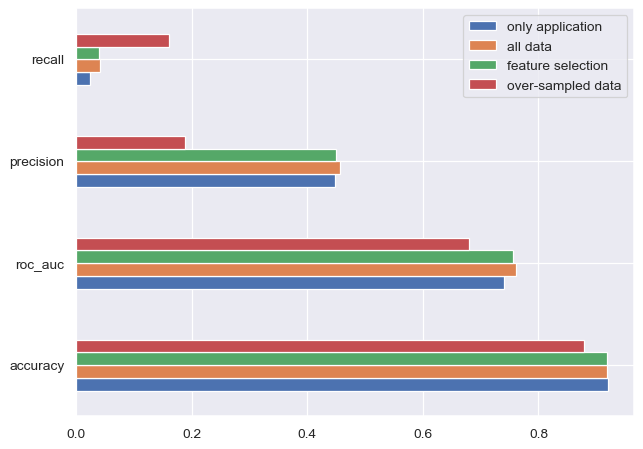

In [190]:
for k in range(2, 5):
    col = name[:k]
    plt.rcParams['figure.figsize'] = [8,6]
    plt.rcParams['figure.dpi'] = 90
    scores.transpose()[col].plot(kind='barh')
    plt.show()

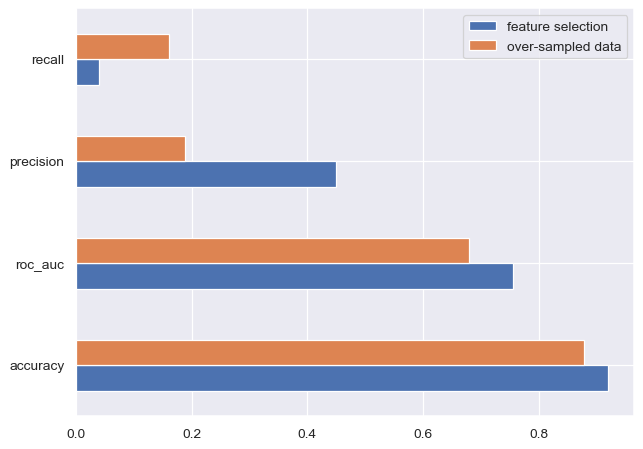

In [203]:
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['figure.dpi'] = 90
scores.transpose()[['feature selection','over-sampled data']].plot(kind='barh')
plt.show()

In [199]:
scores.transpose()

,only application,all data,feature selection,over-sampled data
accuracy,0.919577,0.919447,0.919333,0.878033
roc_auc,0.740520,0.760499,0.755136,0.680459
precision,0.447381,0.456083,0.450113,0.188823
recall,0.024804,0.041271,0.040050,0.160606


## baseline model on application data

In [149]:
pipe_lr = make_pipeline(Imputer(strategy = 'median'),
                       StandardScaler(),
                       LogisticRegression(class_weight='balanced'))

pipe_rf = make_pipeline(Imputer(strategy = 'median'),
                       StandardScaler(),
                       RandomForestClassifier(max_depth=5, class_weight='balanced'))

pipe_ada = make_pipeline(Imputer(strategy = 'median'),
                       StandardScaler(),
                       AdaBoostClassifier())

from collections import defaultdict
scores = defaultdict(list)

In [160]:
train_app = preprocessing.read_application()
train_app = train_app[train_app['TARGET'].isnull() == False]
train = pd.read_csv('train.csv')
train_app.index = train.index

train_app = train_app.ix[rows]

target_app = train_app['TARGET']
train_app = train_app.drop(columns= ['TARGET', 'SK_ID_CURR'])


In [151]:
accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr = kFold(pipe_lr ,train_app, target_app)

scores['accuracy'].append(accuracy)
scores['roc_auc'].append(roc_auc)
scores['precision'].append(precision)
scores['recall'].append(recall)
scores['mean_tpr'].append(mean_tpr)

accuracy, roc_auc, precision, recall, mean_tpr, mean_fpr = kFold(pipe_rf ,train_app, target_app)

scores['accuracy'].append(accuracy)
scores['roc_auc'].append(roc_auc)
scores['precision'].append(precision)
scores['recall'].append(recall)
scores['mean_tpr'].append(mean_tpr)

In [152]:
ss = pd.DataFrame(scores_temp, index=name)

In [153]:
new_tprs= []
new_tprs.append(mean_tprs[0])
new_tprs = new_tprs + scores['mean_tpr']

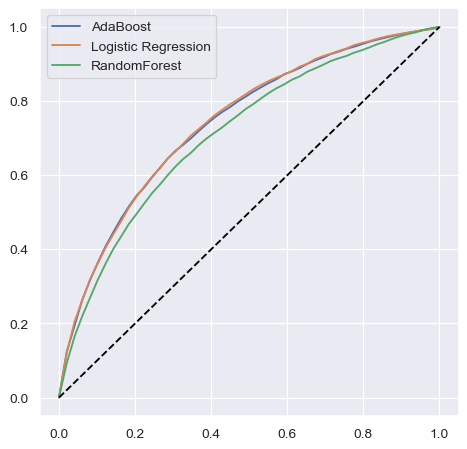

In [154]:
nn = ['AdaBoost', 'Logistic Regression', 'RandomForest']
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['figure.dpi'] = 90
for i in range(3):
    mean_tpr = new_tprs[i]
    plt.plot(mean_fpr, mean_tpr,label = nn[i])
plt.plot([0,1],[0,1],linestyle = '--',color = 'black')
plt.legend()
plt.show()

In [155]:
del scores['mean_tpr']
gc.collect

s = pd.DataFrame(scores)

In [156]:
s = pd.concat([ss.ix[['only application']],s])
s.index = nn

In [157]:
s

,accuracy,roc_auc,precision,recall
AdaBoost,0.919577,0.740520,0.447381,0.024804
Logistic Regression,0.690455,0.742279,0.158660,0.667010
RandomForest,0.682683,0.711944,0.149164,0.629808


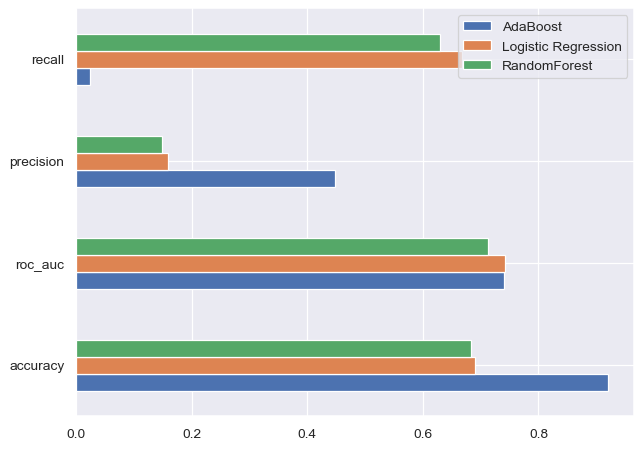

In [158]:
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['figure.dpi'] = 90
s.transpose().plot(kind='barh')
plt.show()

In [161]:
train

,Unnamed: 0,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,previous_app_PRODUCT_COMBINATION_Cash X-Sell: middle_mean,previous_app_PRODUCT_COMBINATION_POS household with interest_mean,previous_app_PRODUCT_COMBINATION_POS household without interest_mean,previous_app_PRODUCT_COMBINATION_POS industry with interest_mean,previous_app_PRODUCT_COMBINATION_POS industry without interest_mean,previous_app_PRODUCT_COMBINATION_POS mobile with interest_mean,previous_app_PRODUCT_COMBINATION_POS mobile without interest_mean,previous_app_PRODUCT_COMBINATION_POS other with interest_mean,previous_app_PRODUCT_COMBINATION_POS others without interest_mean,previous_app_PRODUCT_COMBINATION_nan_mean
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0
3,3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0.00,0.111111,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.166667,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307495,307495,27558.0,254700.0,225000.0,157500.0,NaN,NaN,NaN,NaN,NaN,...,0.00,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0
307496,307496,12001.5,269550.0,225000.0,72000.0,NaN,NaN,NaN,NaN,NaN,...,0.00,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
307497,307497,29979.0,677664.0,585000.0,153000.0,0.0,1.0,1.0,0.0,0.0,...,0.00,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0
307498,307498,20205.0,370107.0,319500.0,171000.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.500000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0


In [185]:
print(ss.ix['feature selction'])

accuracy     0.919333
roc_auc      0.755136
precision    0.450113
recall       0.040050
Name: feature selction, dtype: float64


,NAME_CONTRACT_STATUS_Demand_x,FLAG_DOCUMENT_17,WALLSMATERIAL_MODE_Others,HOUSETYPE_MODE_specific housing,previous_app_SELLERPLACE_AREA_mean,WALLSMATERIAL_MODE_Block,previous_app_NAME_GOODS_CATEGORY_Mobile_mean,previous_app_NAME_GOODS_CATEGORY_Auto Accessories_mean,ORGANIZATION_TYPE_Security,bureau_CREDIT_ACTIVE_Active_mean,...,previous_app_NAME_CASH_LOAN_PURPOSE_Urgent needs_mean,"WALLSMATERIAL_MODE_Stone, brick",ORGANIZATION_TYPE_Trade: type 7,NUM_INSTALMENT_NUMBER_max,MONTHS_BALANCE_min_y,previous_app_PRODUCT_COMBINATION_POS industry with interest_mean,previous_app_CNT_PAYMENT_mean,NONLIVINGAPARTMENTS_AVG,bureau_bureau_balance_max_mean,previous_app_NAME_TYPE_SUITE_Other_B_mean
121958,0.0,0,0,0,18.333333,0,0.166667,0.0,0,0.555556,...,0.0,0,0,12.0,NaN,0.000000,5.666667,0.0000,-0.777778,0.000000
146867,0.0,0,0,0,13.428571,0,0.000000,0.0,0,0.800000,...,0.0,0,0,11.0,NaN,0.142857,48.000000,NaN,-3.000000,0.000000
131932,0.0,0,0,0,12.000000,0,0.000000,0.0,0,0.333333,...,0.0,1,0,108.0,-96.0,0.000000,31.000000,0.0000,NaN,0.000000
259178,0.0,0,0,0,59.666667,0,0.333333,0.0,0,NaN,...,0.0,0,0,10.0,NaN,0.000000,19.333333,NaN,NaN,0.000000
119879,0.0,0,0,0,26.000000,0,1.000000,0.0,0,0.333333,...,0.0,0,0,6.0,NaN,0.000000,6.000000,NaN,-4.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122725,0.0,0,0,0,34.000000,0,0.666667,0.0,0,0.333333,...,0.0,0,0,12.0,-83.0,0.000000,6.666667,NaN,NaN,0.333333
248399,0.0,0,0,0,2358.000000,0,0.000000,0.0,0,0.000000,...,0.0,0,0,12.0,NaN,0.000000,12.000000,0.0193,0.000000,0.000000
165134,0.0,0,0,0,2.666667,0,0.000000,0.0,0,0.666667,...,0.0,0,0,4.0,NaN,0.000000,12.000000,NaN,-27.666667,0.000000
86145,0.0,0,0,0,NaN,0,NaN,NaN,0,0.090909,...,NaN,0,0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
